# Correlation analysis

This notebook examines the correlation structure in the gene expression data generated in [1_create_compendia.ipynb](../processing/1_create_compendia.ipynb).

When we performed clustering on the correlation matrices (using Pearson correlation) we found that pairs of genes had either very high correlation scores (>0.5) or very low correlation scores (<0.1). As a result gene pairs that were highly correlated clustered into a single large module. This clustering pattern is not ideal for a couple of reasons:
1. Given that our goal is to examine the composition of gene groups, having all genes within one module does not allow us to do this
2. These highly correlated group of genes are likely masking other relevant specific signals/relationships in the data

Here we perform two approaches to extracting correlations between genes that correct for this:
1. From [Hibbs et. al.](https://academic.oup.com/bioinformatics/article/23/20/2692/229926), we apply their "signal balancing technique that enhances biological information". This is the first part of their [SPELL](https://spell.yeastgenome.org/) algorithm that is described in section 2.3.1. They apply SVD to the gene expression matrix to reduce the noise that can lead to spurious results and then apply correlation between genes using the singular vector.  Correlations between genes in U equally weight each dimension of the orthonormal basis and balance their contributions such that the least prominent patterns are amplified and more dominant patterns are dampened. This process helps reveal biological signals, as some of the dominant patterns in many microarray datasets are not biologically meaningful (**WHAT ARE THESE DOMINANT SIGNALS???**) Section 2.4 evaluates SPELL on its ability to capture known biology using this balancing approach compared to just applying Pearson correlation. They look to see if groups of related genes are from the same GO term (i.e. do genes from the same GO term cluster together?)

2. From [Zhu et. al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4768301/), we apply their "gene hubbiness correction" procedure. This is part of their [SEEK] algorithm. This correction procedure is motivated by the observation that hubby or well-connected genes in the co-expression network represent global, well-co-expressed processes, and can contaminate the search results regardless of query composition due to the effect of unbalanced gene connectivity in a scale-free co-expression network, and can lead to non-specific results in search or clustering approaches. To avoid the bias created by hubby genes they correct for each gene g’s correlation by subtracting g's average correlation.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import plotnine as pn
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import random
import numpy as np
from scipy.spatial.distance import pdist, squareform
from core_acc_modules import paths

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Set user parameters

For now we will vary the correlation threshold (`corr_threshold`) but keep the other parameters consistent

We will run this notebook for each threshold parameter

In [2]:
# Params
corr_threshold = 0.5

# Output files
pao1_membership_filename = f"pao1_membership_{corr_threshold}.tsv"
pa14_membership_filename = f"pa14_membership_{corr_threshold}.tsv"

In [3]:
# Load expression data
pao1_compendium_filename = paths.PAO1_COMPENDIUM
pa14_compendium_filename = paths.PA14_COMPENDIUM

In [4]:
pao1_compendium = pd.read_csv(pao1_compendium_filename, sep="\t", header=0, index_col=0)
pa14_compendium = pd.read_csv(pa14_compendium_filename, sep="\t", header=0, index_col=0)

In [5]:
print(pao1_compendium.shape)
pao1_compendium.head()

(847, 5563)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541579,150.908951,63.968306,56.863002,86.013480,32.240954,48.322611,21.099413,21.219456,31.521424,12.168960,...,0.000000,16.606783,38.218939,8.611779,28.396413,110.943698,137.583940,101.058282,65.210599,0.000000
ERX541580,108.323515,56.079007,57.001674,73.421480,18.426169,46.572630,16.606703,18.595344,30.253393,15.936006,...,0.000000,13.904292,37.246074,11.777708,45.733000,94.799523,53.486191,82.753701,23.340646,38.113576
ERX541591,556.704228,182.309588,81.730476,157.348561,85.185006,116.643999,36.964524,31.973493,63.109930,16.140763,...,14.312595,73.032021,80.369628,49.312460,69.099677,61.622295,103.911157,186.030844,478.965167,0.000000
ERX541592,428.470250,178.510235,74.953217,152.142022,92.393069,95.317522,33.668009,31.262234,81.131515,20.126563,...,6.691671,114.618032,62.583672,56.426453,58.473904,55.311934,101.620394,207.409539,345.057960,0.000000
ERX676205,555.932721,530.701952,295.028891,336.887163,160.855884,196.799841,24.062303,127.448405,251.543954,29.933785,...,9.935461,59.660341,268.159400,40.929204,30.272774,284.146647,357.806954,260.651493,110.621722,0.000000


In [6]:
print(pa14_compendium.shape)
pa14_compendium.head()

(520, 5891)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX1477379,11.030217,1.370300,0.683438,63.527772,34.586977,4.709054,5.274344,8.137393,5.310585,0.766974,...,10.688588,82.981151,63.650349,28.877599,7.956130,56.829502,269.183334,6.074311,29.079407,100.748813
ERX1477380,13.419626,3.039174,1.334504,105.003820,70.493150,8.849012,6.802855,18.784232,11.978251,2.088495,...,15.823345,91.090917,62.400165,24.819442,3.132517,31.325168,181.774134,10.866863,16.090103,233.317754
ERX1477381,13.155391,5.684725,7.208220,143.201487,107.849795,12.753058,8.868100,27.482294,13.951196,1.251785,...,28.406181,98.909427,71.429549,24.114657,6.515803,18.616579,184.357151,13.112427,13.970424,93.182566
ERX2174773,4.201447,4.194614,3.283683,3.273384,20.188057,3.804287,2.665245,2.650568,20.062716,3.755125,...,41.954387,35.821193,114.727681,104.737209,0.000000,391.722223,160.215744,18.980486,20.985404,182.605858
ERX2174774,5.016892,3.306859,3.446703,2.676762,17.199329,3.748607,1.618736,4.083091,21.225030,2.373772,...,44.138587,26.599121,105.848301,104.402335,0.000000,444.485136,168.538985,24.906987,19.775702,206.865218


## Correlation of raw gene expression data

Use this as a comparison to see how the correlations are changed after each correction method

In [7]:
# Correlation
pao1_corr_original = pao1_compendium.corr()
pa14_corr_original = pa14_compendium.corr()

In [8]:
pao1_corr_original.head(10)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.000000,0.463956,0.569484,0.351438,0.245083,0.082922,-0.237419,0.327681,0.611781,-0.053683,...,-0.143054,0.067547,-0.046884,0.115943,0.095939,0.137961,0.123254,0.413492,-0.017787,-0.044556
PA0002,0.463956,1.000000,0.252376,0.748150,0.165336,-0.064989,-0.223772,0.474954,0.404363,-0.091208,...,-0.049508,-0.029025,0.068886,0.066085,-0.081798,0.364207,0.230212,0.295833,-0.003284,0.026462
PA0003,0.569484,0.252376,1.000000,0.370005,0.231063,0.305920,-0.227813,0.226757,0.414430,0.044911,...,-0.161805,-0.105521,0.058363,-0.032366,0.118532,0.204444,0.136097,0.330368,-0.000470,-0.053666
PA0004,0.351438,0.748150,0.370005,1.000000,0.178458,-0.013829,-0.289639,0.519269,0.406310,-0.039080,...,-0.141347,-0.146768,0.188109,-0.079627,0.004548,0.385017,0.265849,0.248906,-0.068307,-0.074792
PA0005,0.245083,0.165336,0.231063,0.178458,1.000000,0.494013,0.054159,0.548067,0.458342,0.600835,...,0.028263,0.156724,0.147440,0.288880,0.274439,0.158833,-0.076657,0.376051,0.323167,0.055236
PA0006,0.082922,-0.064989,0.305920,-0.013829,0.494013,1.000000,0.081308,0.237252,0.292878,0.513892,...,-0.016893,0.096924,0.010410,0.117019,0.360544,-0.003778,-0.102584,0.271246,0.500298,0.151742
PA0007,-0.237419,-0.223772,-0.227813,-0.289639,0.054159,0.081308,1.000000,-0.046221,-0.216576,0.324133,...,0.271006,0.185148,0.153610,0.229573,0.014695,-0.157321,-0.194364,-0.228108,-0.011214,-0.075471
PA0008,0.327681,0.474954,0.226757,0.519269,0.548067,0.237252,-0.046221,1.000000,0.622803,0.422828,...,0.025600,0.171674,0.098219,0.160160,0.275832,0.292958,-0.004170,0.373103,0.033407,-0.062744
PA0009,0.611781,0.404363,0.414430,0.406310,0.458342,0.292878,-0.216576,0.622803,1.000000,0.323238,...,-0.086027,0.190834,0.041047,0.263861,0.181747,0.288218,0.090151,0.649253,0.211386,0.008422
PA0010,-0.053683,-0.091208,0.044911,-0.039080,0.600835,0.513892,0.324133,0.422828,0.323238,1.000000,...,0.214372,0.368324,0.054038,0.459551,0.241080,-0.065073,-0.135702,0.145646,0.278227,-0.063221


In [9]:
pa14_corr_original.head(10)

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
PA14_55610,1.000000,0.906701,0.749071,0.162668,0.266153,0.275753,0.588848,0.160785,0.652794,0.713892,...,0.533793,0.227351,0.082841,0.063174,-0.024971,0.059939,-0.029175,0.624167,0.613477,0.070253
PA14_55600,0.906701,1.000000,0.850899,0.156404,0.262327,0.288455,0.564872,0.168042,0.658406,0.723227,...,0.632673,0.222953,0.106674,0.046272,-0.023670,0.043219,-0.103563,0.674299,0.422937,0.040578
PA14_55590,0.749071,0.850899,1.000000,0.130853,0.193168,0.197765,0.359634,0.122212,0.499659,0.527222,...,0.504701,0.143781,0.075238,0.017656,-0.022301,-0.049487,-0.116984,0.452168,0.357768,0.019400
PA14_55580,0.162668,0.156404,0.130853,1.000000,0.715461,0.157864,0.189221,0.072951,0.250444,0.106665,...,0.104985,-0.140209,-0.251613,0.036440,-0.012161,0.073282,-0.040502,0.057864,0.101350,0.067545
PA14_55570,0.266153,0.262327,0.193168,0.715461,1.000000,0.362644,0.379303,0.366620,0.440662,0.297628,...,0.223022,-0.112091,-0.224259,0.063502,-0.031547,0.048680,-0.072413,0.155098,0.139406,0.086553
PA14_55560,0.275753,0.288455,0.197765,0.157864,0.362644,1.000000,0.796257,0.228080,0.478695,0.591215,...,0.192297,-0.020132,-0.082234,0.009302,0.017292,-0.008538,-0.086910,0.256650,0.118795,0.243433
PA14_55550,0.588848,0.564872,0.359634,0.189221,0.379303,0.796257,1.000000,0.294181,0.650316,0.821997,...,0.376162,0.110074,0.038220,0.043972,0.026152,0.064738,-0.040994,0.545006,0.291638,0.144242
PA14_55540,0.160785,0.168042,0.122212,0.072951,0.366620,0.228080,0.294181,1.000000,0.220546,0.288728,...,0.100791,0.008243,-0.127802,-0.016647,-0.018001,0.161880,-0.136225,0.134484,0.091419,-0.046814
PA14_55530,0.652794,0.658406,0.499659,0.250444,0.440662,0.478695,0.650316,0.220546,1.000000,0.789647,...,0.645462,0.190459,-0.055140,0.079046,-0.026326,-0.020371,-0.089501,0.611433,0.432119,0.201573
PA14_55520,0.713892,0.723227,0.527222,0.106665,0.297628,0.591215,0.821997,0.288728,0.789647,1.000000,...,0.570803,0.176055,0.087168,0.060785,-0.016582,0.001728,-0.088387,0.764914,0.383719,0.061344


## SPELL

_Review of SVD_

Singular Value Decomposition is a way to decompose your matrix, $X^{mxn}$ into 3 matrices: $X = U \Sigma V^*$

In our case $X$ is gene x sample and then the columns of $U$ (gene x gene) are the left singular vectors (gene coefficient vectors); $\Sigma$ (the same dimensions as $X$) has singular values and is diagonal (mode amplitudes); and $V^T$ (sample x sample) has rows that are the right singular vectors (expression level vectors).

In [10]:
# Transpose compendia to be gene x sample
pao1_compendium_T = pao1_compendium.T
pa14_compendium_T = pa14_compendium.T

In [11]:
# Apply SVD
pao1_U, pao1_s, pao1_Vh = np.linalg.svd(pao1_compendium_T, full_matrices=False)
pa14_U, pa14_s, pa14_Vh = np.linalg.svd(pa14_compendium_T, full_matrices=False)

In [12]:
print(pao1_compendium.shape)
print(pao1_U.shape, pao1_s.shape, pao1_Vh.shape)

(847, 5563)
(5563, 847) (847,) (847, 847)


In [13]:
print(pa14_compendium.shape)
print(pa14_U.shape, pa14_s.shape, pa14_Vh.shape)

(520, 5891)
(5891, 520) (520,) (520, 520)


In [14]:
# Convert ndarray to df to use corr()
pao1_U_df = pd.DataFrame(
    data=pao1_U, index=pao1_compendium_T.index, columns=pao1_compendium_T.columns
)
pa14_U_df = pd.DataFrame(
    data=pa14_U, index=pa14_compendium_T.index, columns=pa14_compendium_T.columns
)

In [15]:
pao1_U_df.head()

,ERX541579,ERX541580,ERX541591,ERX541592,ERX676205,ERX676206,ERX676207,ERX676208,ERX676209,ERX676210,...,SRX9370135,SRX9370136,SRX9370137,SRX9370138,SRX9370139,SRX9370140,SRX9370141,SRX9370142,SRX9370143,SRX9370144
PA0001,-0.000499,0.003928,0.000161,0.000991,0.004221,0.005287,0.003215,-0.001215,0.000429,-0.003301,...,0.000102,0.026068,0.018979,0.013367,0.007391,0.006881,-0.003159,0.007491,0.002917,-0.012352
PA0002,-0.000571,0.004696,0.000377,0.001109,0.004161,0.007611,0.002265,-0.001126,0.000685,-0.005943,...,0.011190,0.031214,0.038086,-0.017773,0.036547,0.001976,0.008841,0.014507,0.006884,0.019785
PA0003,-0.000410,0.002993,0.000067,0.000592,0.003538,0.003745,0.001793,-0.000601,0.000136,-0.001969,...,0.059264,-0.010148,-0.018930,0.006628,-0.014706,0.000576,-0.005655,0.004718,-0.027775,-0.014643
PA0004,-0.000451,0.003720,0.000140,0.000075,0.003774,0.005970,0.002148,0.000112,0.000226,-0.005934,...,0.001690,0.038703,0.023531,-0.021590,0.032037,0.018646,-0.011879,-0.007102,0.002021,0.013599
PA0005,-0.000138,0.001107,0.000039,0.000043,0.000933,0.001793,0.000557,-0.000328,0.000025,-0.000826,...,-0.017318,-0.006797,0.008385,-0.016335,0.017065,-0.020169,0.001941,0.006049,-0.010133,0.011671


In [16]:
# Correlation of U
# Since `corr()` computes pairwise correlation of columns we need to invert U
pao1_corr_spell = pao1_U_df.T.corr()
pa14_corr_spell = pa14_U_df.T.corr()

In [17]:
# Create a similarity matrix usingn the threshold defined above
# The similarity matrix will determine the strength of the connection between two genes
# If the concordance is strong enough (i.e. above the threshold), then
# the genes are connected by by the correlation score, otherwise the value is set to 0
# pao1_corr_spell[pao1_corr_spell.abs() < corr_threshold] = 0.0
# pa14_corr_spell[pa14_corr_spell.abs() < corr_threshold] = 0.0

In [18]:
# pao1_corr_spell.head()

<Figure size 1440x1440 with 0 Axes>

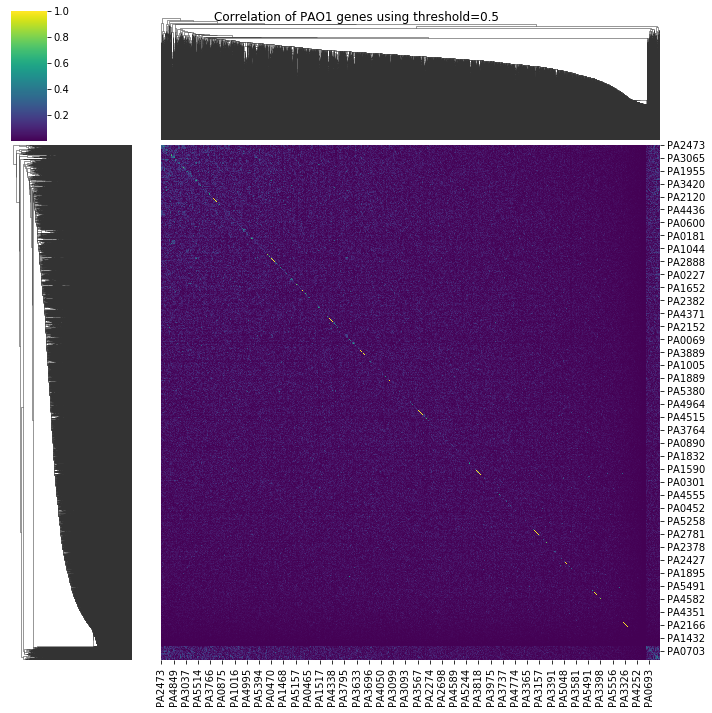

In [19]:
# Plot heatmap
plt.figure(figsize=(20, 20))
h1 = sns.clustermap(pao1_corr_spell.abs(), cmap="viridis")
h1.fig.suptitle(f"Correlation of PAO1 genes using threshold={corr_threshold}")

# Save
pao1_clustermap_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_corr_{corr_threshold}_clustermap.png"
)
# h1.savefig(pao1_clustermap_filename, dpi=300)

<Figure size 1440x1440 with 0 Axes>

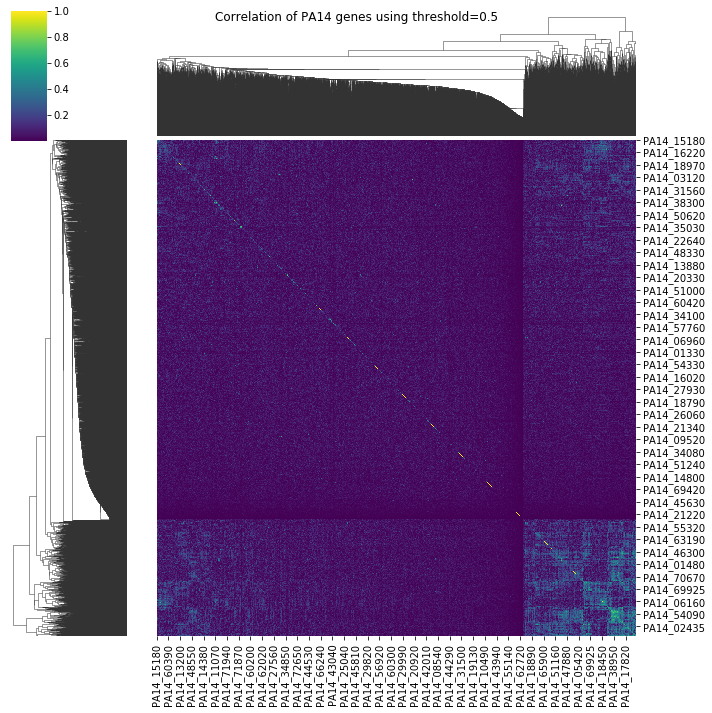

In [20]:
plt.figure(figsize=(20, 20))
h2 = sns.clustermap(pa14_corr_spell.abs(), cmap="viridis")
h2.fig.suptitle(f"Correlation of PA14 genes using threshold={corr_threshold}")

# Save
pa14_clustermap_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_corr_{corr_threshold}_clustermap.png"
)
# h2.savefig(pa14_clustermap_filename, dpi=300)

## SEEK

In [21]:
# Correlation of U
pao1_corr_seek = pao1_compendium.corr()
pa14_corr_seek = pa14_compendium.corr()

In [22]:
# Subtract mean correlation score for gene
pao1_corr_mean = pao1_corr_seek.mean()
pa14_corr_mean = pa14_corr_seek.mean()

pao1_corr_mean

PA0001     -0.016509
PA0002     -0.061601
PA0003      0.001824
PA0004     -0.037507
PA0005      0.275654
PA0006      0.227880
PA0007      0.169787
PA0008      0.209242
PA0009      0.126632
PA0010      0.382994
PA0011      0.167509
PA0012      0.194019
PA0013      0.275311
PA0014      0.254982
PA0015      0.276021
PA0016      0.335018
PA0017      0.369212
PA0018      0.364034
PA0019     -0.028232
PA0020      0.069432
PA0021      0.371338
PA0022      0.234952
PA0023      0.288956
PA0024      0.073971
PA0025      0.182447
PA0026      0.196341
PA0027      0.317944
PA0028      0.342522
PA0029      0.393820
PA0030      0.410006
              ...   
PA5552      0.287680
PA5553     -0.110804
PA5554     -0.120891
PA5555     -0.113009
PA5556     -0.104618
PA5557     -0.096427
PA5558     -0.128848
PA5559     -0.141552
PA5560     -0.072486
PA5561     -0.031384
PA5562      0.133096
PA5563      0.135198
PA5564      0.227460
PA5565      0.171311
PA5566      0.367153
PA5567      0.392363
PA5568      0

In [23]:
pao1_corr_corrected = pao1_corr_seek - pao1_corr_mean
pa14_corr_corrected = pa14_corr_seek - pa14_corr_mean

In [24]:
pao1_corr_seek.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.000000,0.463956,0.569484,0.351438,0.245083,0.082922,-0.237419,0.327681,0.611781,-0.053683,...,-0.143054,0.067547,-0.046884,0.115943,0.095939,0.137961,0.123254,0.413492,-0.017787,-0.044556
PA0002,0.463956,1.000000,0.252376,0.748150,0.165336,-0.064989,-0.223772,0.474954,0.404363,-0.091208,...,-0.049508,-0.029025,0.068886,0.066085,-0.081798,0.364207,0.230212,0.295833,-0.003284,0.026462
PA0003,0.569484,0.252376,1.000000,0.370005,0.231063,0.305920,-0.227813,0.226757,0.414430,0.044911,...,-0.161805,-0.105521,0.058363,-0.032366,0.118532,0.204444,0.136097,0.330368,-0.000470,-0.053666
PA0004,0.351438,0.748150,0.370005,1.000000,0.178458,-0.013829,-0.289639,0.519269,0.406310,-0.039080,...,-0.141347,-0.146768,0.188109,-0.079627,0.004548,0.385017,0.265849,0.248906,-0.068307,-0.074792
PA0005,0.245083,0.165336,0.231063,0.178458,1.000000,0.494013,0.054159,0.548067,0.458342,0.600835,...,0.028263,0.156724,0.147440,0.288880,0.274439,0.158833,-0.076657,0.376051,0.323167,0.055236


In [25]:
# Notice that the corrected correlation matrix is not symmetric anymore because we
# are subtracting the mean for each row
pao1_corr_corrected.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.016509,0.525557,0.567660,0.388945,-0.030571,-0.144958,-0.407205,0.118439,0.485149,-0.436677,...,-0.264777,-0.125133,-0.086719,-0.093461,-0.099568,0.205276,0.207604,0.374105,-0.146101,-0.029674
PA0002,0.480465,1.061601,0.250552,0.785657,-0.110317,-0.292869,-0.393558,0.265712,0.277731,-0.474201,...,-0.171231,-0.221705,0.029051,-0.143319,-0.277305,0.431522,0.314562,0.256446,-0.131599,0.041345
PA0003,0.585993,0.313977,0.998176,0.407511,-0.044591,0.078040,-0.397599,0.017515,0.287798,-0.338083,...,-0.283528,-0.298201,0.018528,-0.241770,-0.076975,0.271759,0.220447,0.290981,-0.128785,-0.038783
PA0004,0.367947,0.809751,0.368180,1.037507,-0.097196,-0.241709,-0.459426,0.310027,0.279678,-0.422074,...,-0.263070,-0.339449,0.148275,-0.289031,-0.190959,0.452332,0.350200,0.209518,-0.196621,-0.059910
PA0005,0.261592,0.226937,0.229238,0.215965,0.724346,0.266133,-0.115627,0.338825,0.331711,0.217842,...,-0.093460,-0.035956,0.107605,0.079476,0.078932,0.226148,0.007694,0.336664,0.194853,0.070119


In [26]:
pa14_corr_corrected.head()

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
PA14_55610,0.712582,0.608219,0.534755,0.087413,0.143331,0.169002,0.358476,0.097092,0.381058,0.426289,...,0.250332,0.104724,-0.013820,0.001755,-0.003865,0.031528,-0.022886,0.317681,0.450579,0.053755
PA14_55600,0.619283,0.701518,0.636584,0.081149,0.139505,0.181704,0.334500,0.104349,0.386669,0.435624,...,0.349211,0.100327,0.010013,-0.015147,-0.002564,0.014808,-0.097274,0.367813,0.260039,0.024081
PA14_55590,0.461652,0.552418,0.785685,0.055598,0.070346,0.091014,0.129262,0.058519,0.227922,0.239619,...,0.221240,0.021155,-0.021423,-0.043762,-0.001195,-0.077899,-0.110695,0.145682,0.194870,0.002902
PA14_55580,-0.124751,-0.142078,-0.083462,0.924745,0.592639,0.051112,-0.041151,0.009258,-0.021293,-0.180938,...,-0.178477,-0.262836,-0.348274,-0.024979,0.008944,0.044871,-0.034212,-0.248621,-0.061548,0.051047
PA14_55570,-0.021266,-0.036155,-0.021147,0.640206,0.877178,0.255893,0.148931,0.302927,0.168926,0.010025,...,-0.060439,-0.234718,-0.320919,0.002084,-0.010441,0.020268,-0.066124,-0.151388,-0.023491,0.070056


In [27]:
# Create a similarity matrix usingn the threshold defined above
# The similarity matrix will determine the strength of the connection between two genes
# If the concordance is strong enough (i.e. above the threshold), then
# the genes are connected by by the correlation score, otherwise the value is set to 0
# pao1_corr_corrected[pao1_corr_corrected.abs() < corr_threshold] = 0.0
# pa14_corr_corrected[pa14_corr_corrected.abs() < corr_threshold] = 0.0

# pao1_corr_corrected.head()

<Figure size 1440x1440 with 0 Axes>

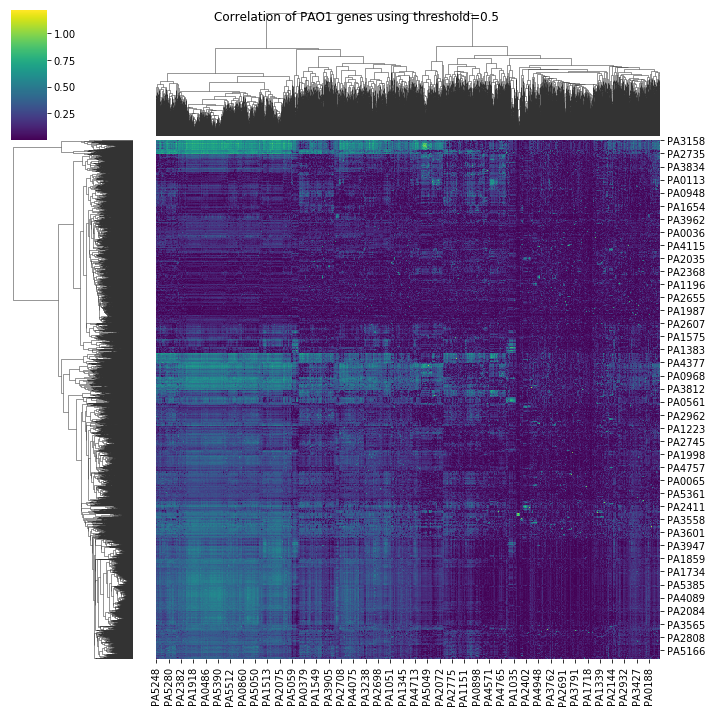

In [28]:
# Plot heatmap
plt.figure(figsize=(20, 20))
h1 = sns.clustermap(pao1_corr_corrected.abs(), cmap="viridis")
h1.fig.suptitle(f"Correlation of PAO1 genes using threshold={corr_threshold}")

# Save
pao1_clustermap_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_corr_{corr_threshold}_clustermap.png"
)
# h1.savefig(pao1_clustermap_filename, dpi=300)

<Figure size 1440x1440 with 0 Axes>

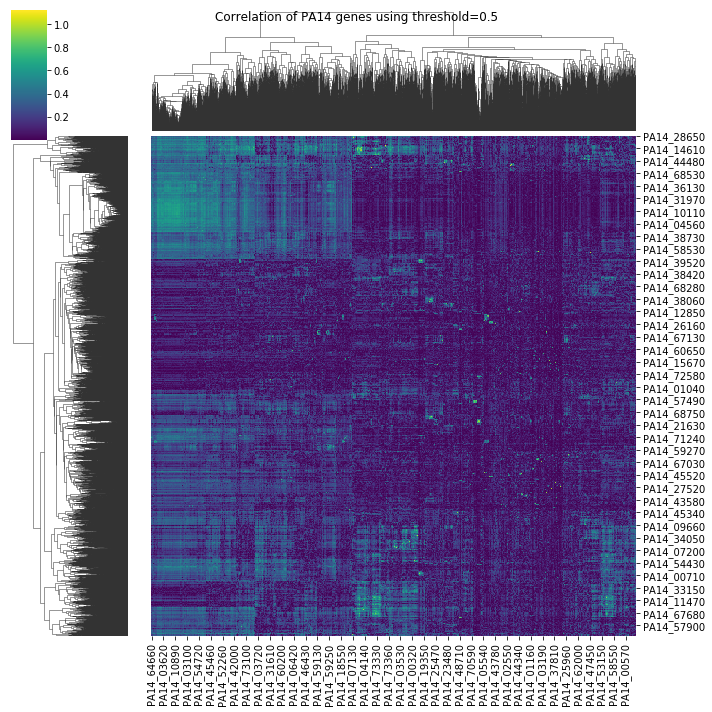

In [29]:
plt.figure(figsize=(20, 20))
h2 = sns.clustermap(pa14_corr_corrected.abs(), cmap="viridis")
h2.fig.suptitle(f"Correlation of PA14 genes using threshold={corr_threshold}")

# Save
pa14_clustermap_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_corr_{corr_threshold}_clustermap.png"
)
# h2.savefig(pa14_clustermap_filename, dpi=300)

In [30]:
"""# Save
pao1_corr_filename = f"pao1_corr_{corr_threshold}.tsv"
pa14_corr_filename = f"pa14_corr_{corr_threshold}.tsv"
pao1_corr.to_csv(os.path.join(paths.LOCAL_DATA_DIR, pao1_corr_filename), sep="\t")
pa14_corr.to_csv(os.path.join(paths.LOCAL_DATA_DIR, pa14_corr_filename), sep="\t")"""

NameError: name 'pao1_corr' is not defined

**Takeaway:**

Here we are visualizing the clustering of raw correlation scores where values < `corr_threshold` are set to 0. If we compare the clustermap results in this notebook with [1a_get_network_communities_complex.ipynb](1a_get_network_communities_complex.ipynb) where we cluster the on the Topological Overlap Matrix (TOM) we see:
* Clustering pattern between using raw correlation score vs TOM is similar. TOM is considering secondary relationships (i.e. gene _i_ and _j_ are similar if they are linked in the adjacency matrix and gene _i_ is connected to all the neighbors of gene _j_)
* At thresholds 0.5, 0.6 there seems to be 1 large cluster, some very smaller clusters, then all other genes that are below the threshold
* As we increase the threshold to 0.8 and 0.9, this very large cluster is broken up into more equal sized smaller clusters
* In terms of distance, for threshold of 0.5, 0.6 high density regions look like those > 20. For thresholds 0.7-0.9, high density regions look like those > 15.

Overall, clustering may make sense using higher thresholds (0.8, 0.9) and excluding the community containing the remaining genes. However then we are not left with many genes, so perhaps it makes sense to consider a different similarity/correlation metric to use?
* Looking at the pair plots of the raw expression data (estimated counts - an estimate of the number of reads drawn from this transcript given the transcript’s relative abundance and length). There is a tendency for genes to have a long right tail where some genes have a spike at 0 and some do not. In this case Spearman correlation might be more appropriate here.

After meeting with Casey, the main takeaway is that:
* It appears that the TOM matrix is not as sensitive since its setting nearby genes to have a score of 1.
Using just the correlation score is grouping genes into one large cluster.
* To dappen the overwhelming signal of highly correlated genes we will look into applying these two methods:
https://pubmed.ncbi.nlm.nih.gov/17724061/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4768301/